# 10y Bond Forecasting with LSTMs

In [63]:
import os
import sys
import pandas as pd
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Bidirectional, LSTM, GRU, Flatten, Dropout
from keras.regularizers import L1L2
from keras import backend as K
import tensorflow as tf
from tensorflow.python.client import device_lib
from bokeh.io import output_notebook
from utils import (get_number_processors, plot_series, to_1dimension, plot_series_prediction, plot_model_history, save_model, mean_absolute_percentage_error)
from techind_utils import (CCI, SMA, EWMA, ROC, BBANDS)

from matplotlib import pyplot

print("OS: ", sys.platform)
print("Python: ", sys.version)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tf.__version__)
print("Numpy: ", np.__version__)
print("Number of CPU processors: ", get_number_processors())



output_notebook()

OS:  linux
Python:  3.5.2 (default, Nov 23 2017, 16:37:01) 
[GCC 5.4.0 20160609]
Keras:  2.1.5
Tensorflow:  1.7.0
Numpy:  1.14.2
Number of CPU processors:  1


Loading BokehJS ...

In [64]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16247978504926408563
]


In [65]:
K.tensorflow_backend._get_available_gpus()

[]

### Data

In [66]:
DATA = os.path.join('data', 'test_bond.csv')
TEST_SIZE = 0.3
EPOCHS = 200
TIME_AHEAD = 1 #prediction step
BATCH_SIZE = 64
UNITS = 100
OPT = 'adam'

In [67]:
df_bond = pd.read_csv(DATA)

In [68]:
df_bond['datetime'] = pd.to_datetime(df_bond.date)

In [69]:
df_bond.sort_values(by='datetime', ascending=True, inplace=True)

In [70]:
print(df_bond.shape)

(14362, 3)


In [71]:
df_bond.head()

,date,10Y Bond,datetime
14361,1948-12-31,2.49,1948-12-31
14360,1949-12-30,2.47,1949-12-30
14359,1950-12-29,2.32,1950-12-29
14358,1951-12-31,2.57,1951-12-31
14357,1952-12-31,2.68,1952-12-31


In [72]:
# Commodity Channel Index
df_bond = CCI(df_bond, 20)
df_bond = CCI(df_bond, 40)

In [73]:
df_bond.tail()

,date,10Y Bond,datetime,CCI_20,CCI_40
4,2018-02-25,2.875,2018-02-25,18.283891,65.637381
3,2018-02-26,2.864,2018-02-26,2.195877,57.214259
2,2018-02-27,2.901,2018-02-27,47.200365,73.025888
1,2018-02-28,2.864,2018-02-28,-17.004773,51.061276
0,2018-03-01,2.848,2018-03-01,-56.953090,39.845062


In [74]:
#Moving average (MA)
df_bond = SMA(df_bond, 5)
df_bond = SMA(df_bond, 10)
df_bond = SMA(df_bond, 20)
df_bond = SMA(df_bond, 50)
df_bond = SMA(df_bond, 200)

In [75]:
df_bond = EWMA(df_bond, 5)
df_bond = EWMA(df_bond, 10)
df_bond = EWMA(df_bond, 20)
df_bond = EWMA(df_bond, 50)
df_bond = EWMA(df_bond, 200)

In [76]:
df_bond.tail()

,date,10Y Bond,datetime,CCI_20,CCI_40,SMA_5,SMA_10,SMA_20,SMA_50,SMA_200,EWMA_5,EWMA_10,EWMA_20,EWMA_50,EWMA_200
4,2018-02-25,2.875,2018-02-25,18.283891,65.637381,2.9006,2.8957,2.86120,2.68552,2.398870,2.888807,2.883021,2.844832,2.719182,2.465136
3,2018-02-26,2.864,2018-02-26,2.195877,57.214259,2.8952,2.8908,2.86235,2.69454,2.401450,2.880538,2.879563,2.846657,2.724862,2.469105
2,2018-02-27,2.901,2018-02-27,47.200365,73.025888,2.8850,2.8903,2.86515,2.70388,2.404285,2.887359,2.883461,2.851833,2.731769,2.473402
1,2018-02-28,2.864,2018-02-28,-17.004773,51.061276,2.8740,2.8894,2.87290,2.71306,2.406970,2.879572,2.879922,2.852992,2.736954,2.477289
0,2018-03-01,2.848,2018-03-01,-56.953090,39.845062,2.8704,2.8869,2.87505,2.72192,2.409370,2.869048,2.874118,2.852516,2.741309,2.480978


In [77]:
# Rate of Change (ROC)
df_bond = ROC(df_bond, 12)
df_bond = ROC(df_bond, 14)
df_bond = ROC(df_bond, 21)
df_bond = ROC(df_bond, 25)
df_bond = ROC(df_bond, 63)
df_bond = ROC(df_bond, 125)
df_bond = ROC(df_bond, 250)

In [78]:
df_bond.tail()

,date,10Y Bond,datetime,CCI_20,CCI_40,SMA_5,SMA_10,SMA_20,SMA_50,SMA_200,...,EWMA_20,EWMA_50,EWMA_200,ROC_12,ROC_14,ROC_21,ROC_25,ROC_63,ROC_125,ROC_250
4,2018-02-25,2.875,2018-02-25,18.283891,65.637381,2.9006,2.8957,2.86120,2.68552,2.398870,...,2.844832,2.719182,2.465136,0.006300,0.016620,0.060103,0.080827,0.202929,0.245667,0.222364
3,2018-02-26,2.864,2018-02-26,2.195877,57.214259,2.8952,2.8908,2.86235,2.69454,2.401450,...,2.846657,2.724862,2.469105,0.002099,0.002450,0.029475,0.077502,0.191844,0.224455,0.218723
2,2018-02-27,2.901,2018-02-27,47.200365,73.025888,2.8850,2.8903,2.86515,2.70388,2.404285,...,2.851833,2.731769,2.473402,0.024003,0.015401,0.021119,0.074843,0.235520,0.238685,0.229237
1,2018-02-28,2.864,2018-02-28,-17.004773,51.061276,2.8740,2.8894,2.87290,2.71306,2.406970,...,2.852992,2.736954,2.477289,-0.016821,0.002099,0.006678,0.051395,0.219242,0.223409,0.198828
0,2018-03-01,2.848,2018-03-01,-56.953090,39.845062,2.8704,2.8869,2.87505,2.72192,2.409370,...,2.852516,2.741309,2.480978,-0.019959,0.005295,0.051310,0.050147,0.211399,0.224946,0.187656


In [79]:
# Compute the Bollinger Bands 
df_bond = BBANDS(df_bond, 20)
df_bond = BBANDS(df_bond, 50)

In [80]:
df_bond.tail()

,date,10Y Bond,datetime,CCI_20,CCI_40,SMA_5,SMA_10,SMA_20,SMA_50,SMA_200,...,ROC_14,ROC_21,ROC_25,ROC_63,ROC_125,ROC_250,UpperBB_20,LowerBB_20,UpperBB_50,LowerBB_50
4,2018-02-25,2.875,2018-02-25,18.283891,65.637381,2.9006,2.8957,2.86120,2.68552,2.398870,...,0.016620,0.060103,0.080827,0.202929,0.245667,0.222364,2.961835,2.760565,3.024120,2.346920
3,2018-02-26,2.864,2018-02-26,2.195877,57.214259,2.8952,2.8908,2.86235,2.69454,2.401450,...,0.002450,0.029475,0.077502,0.191844,0.224455,0.218723,2.962538,2.762162,3.027490,2.361590
2,2018-02-27,2.901,2018-02-27,47.200365,73.025888,2.8850,2.8903,2.86515,2.70388,2.404285,...,0.015401,0.021119,0.074843,0.235520,0.238685,0.229237,2.966420,2.763880,3.033179,2.374581
1,2018-02-28,2.864,2018-02-28,-17.004773,51.061276,2.8740,2.8894,2.87290,2.71306,2.406970,...,0.002099,0.006678,0.051395,0.219242,0.223409,0.198828,2.942684,2.803116,3.033832,2.392288
0,2018-03-01,2.848,2018-03-01,-56.953090,39.845062,2.8704,2.8869,2.87505,2.72192,2.409370,...,0.005295,0.051310,0.050147,0.211399,0.224946,0.187656,2.938377,2.811723,3.032264,2.411576


In [81]:
df_bond.head()

,date,10Y Bond,datetime,CCI_20,CCI_40,SMA_5,SMA_10,SMA_20,SMA_50,SMA_200,...,ROC_14,ROC_21,ROC_25,ROC_63,ROC_125,ROC_250,UpperBB_20,LowerBB_20,UpperBB_50,LowerBB_50
14361,1948-12-31,2.49,1948-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14360,1949-12-30,2.47,1949-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14359,1950-12-29,2.32,1950-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14358,1951-12-31,2.57,1951-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14357,1952-12-31,2.68,1952-12-31,NaN,NaN,2.506,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
super_df_bond = df_bond.dropna(axis=0, how='any')

In [83]:
super_df_bond.head()

,date,10Y Bond,datetime,CCI_20,CCI_40,SMA_5,SMA_10,SMA_20,SMA_50,SMA_200,...,ROC_14,ROC_21,ROC_25,ROC_63,ROC_125,ROC_250,UpperBB_20,LowerBB_20,UpperBB_50,LowerBB_50
14111,1962-12-12,3.88,1962-12-12,-172.036473,-157.860125,3.900,3.914,3.9180,3.9200,3.93025,...,-0.010204,-0.002571,-0.007673,-0.030000,0.005181,0.558233,3.947451,3.888549,3.952826,3.887174
14110,1962-12-13,3.88,1962-12-13,-143.608792,-145.297992,3.892,3.910,3.9165,3.9188,3.92965,...,-0.010204,-0.005128,-0.007673,-0.030000,0.002584,0.570850,3.950388,3.882612,3.953000,3.884600
14109,1962-12-14,3.87,1962-12-14,-149.368746,-166.531755,3.884,3.905,3.9145,3.9176,3.92895,...,-0.015267,-0.010230,-0.010230,-0.032500,-0.007692,0.668103,3.954223,3.874777,3.954314,3.880886
14108,1962-12-17,3.85,1962-12-17,-166.908042,-205.820478,3.874,3.897,3.9105,3.9162,3.92820,...,-0.017857,-0.015345,-0.012821,-0.035088,-0.010283,0.498054,3.958830,3.862170,3.957582,3.874818
14107,1962-12-18,3.83,1962-12-18,-169.800624,-222.269204,3.862,3.886,3.9055,3.9148,3.92745,...,-0.022959,-0.025445,-0.015424,-0.040100,-0.020460,0.429104,3.964785,3.846215,3.962650,3.866950


In [84]:
df_bond.head()

,date,10Y Bond,datetime,CCI_20,CCI_40,SMA_5,SMA_10,SMA_20,SMA_50,SMA_200,...,ROC_14,ROC_21,ROC_25,ROC_63,ROC_125,ROC_250,UpperBB_20,LowerBB_20,UpperBB_50,LowerBB_50
14361,1948-12-31,2.49,1948-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14360,1949-12-30,2.47,1949-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14359,1950-12-29,2.32,1950-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14358,1951-12-31,2.57,1951-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14357,1952-12-31,2.68,1952-12-31,NaN,NaN,2.506,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
#super_df_bond.sort_values(by='datetime', ascending=False, inplace=True)

In [86]:
super_df_bond.drop(columns=['datetime'], inplace=True)

/home/dmytromaliarenko/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [87]:
super_df_bond.head()

,date,10Y Bond,CCI_20,CCI_40,SMA_5,SMA_10,SMA_20,SMA_50,SMA_200,EWMA_5,...,ROC_14,ROC_21,ROC_25,ROC_63,ROC_125,ROC_250,UpperBB_20,LowerBB_20,UpperBB_50,LowerBB_50
14111,1962-12-12,3.88,-172.036473,-157.860125,3.900,3.914,3.9180,3.9200,3.93025,3.897301,...,-0.010204,-0.002571,-0.007673,-0.030000,0.005181,0.558233,3.947451,3.888549,3.952826,3.887174
14110,1962-12-13,3.88,-143.608792,-145.297992,3.892,3.910,3.9165,3.9188,3.92965,3.891534,...,-0.010204,-0.005128,-0.007673,-0.030000,0.002584,0.570850,3.950388,3.882612,3.953000,3.884600
14109,1962-12-14,3.87,-149.368746,-166.531755,3.884,3.905,3.9145,3.9176,3.92895,3.884356,...,-0.015267,-0.010230,-0.010230,-0.032500,-0.007692,0.668103,3.954223,3.874777,3.954314,3.880886
14108,1962-12-17,3.85,-166.908042,-205.820478,3.874,3.897,3.9105,3.9162,3.92820,3.872904,...,-0.017857,-0.015345,-0.012821,-0.035088,-0.010283,0.498054,3.958830,3.862170,3.957582,3.874818
14107,1962-12-18,3.83,-169.800624,-222.269204,3.862,3.886,3.9055,3.9148,3.92745,3.858603,...,-0.022959,-0.025445,-0.015424,-0.040100,-0.020460,0.429104,3.964785,3.846215,3.962650,3.866950


In [88]:
super_df_bond.tail()

,date,10Y Bond,CCI_20,CCI_40,SMA_5,SMA_10,SMA_20,SMA_50,SMA_200,EWMA_5,...,ROC_14,ROC_21,ROC_25,ROC_63,ROC_125,ROC_250,UpperBB_20,LowerBB_20,UpperBB_50,LowerBB_50
4,2018-02-25,2.875,18.283891,65.637381,2.9006,2.8957,2.86120,2.68552,2.398870,2.888807,...,0.016620,0.060103,0.080827,0.202929,0.245667,0.222364,2.961835,2.760565,3.024120,2.346920
3,2018-02-26,2.864,2.195877,57.214259,2.8952,2.8908,2.86235,2.69454,2.401450,2.880538,...,0.002450,0.029475,0.077502,0.191844,0.224455,0.218723,2.962538,2.762162,3.027490,2.361590
2,2018-02-27,2.901,47.200365,73.025888,2.8850,2.8903,2.86515,2.70388,2.404285,2.887359,...,0.015401,0.021119,0.074843,0.235520,0.238685,0.229237,2.966420,2.763880,3.033179,2.374581
1,2018-02-28,2.864,-17.004773,51.061276,2.8740,2.8894,2.87290,2.71306,2.406970,2.879572,...,0.002099,0.006678,0.051395,0.219242,0.223409,0.198828,2.942684,2.803116,3.033832,2.392288
0,2018-03-01,2.848,-56.953090,39.845062,2.8704,2.8869,2.87505,2.72192,2.409370,2.869048,...,0.005295,0.051310,0.050147,0.211399,0.224946,0.187656,2.938377,2.811723,3.032264,2.411576


In [89]:
super_df_bond.rename(columns={"10Y Bond": "10Y Bond t-1"},inplace=True)

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [90]:
super_df_bond['target'] = super_df_bond['10Y Bond t-1'].shift(-1)

/home/dmytromaliarenko/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [91]:
super_df_bond.tail()

,date,10Y Bond t-1,CCI_20,CCI_40,SMA_5,SMA_10,SMA_20,SMA_50,SMA_200,EWMA_5,...,ROC_21,ROC_25,ROC_63,ROC_125,ROC_250,UpperBB_20,LowerBB_20,UpperBB_50,LowerBB_50,target
4,2018-02-25,2.875,18.283891,65.637381,2.9006,2.8957,2.86120,2.68552,2.398870,2.888807,...,0.060103,0.080827,0.202929,0.245667,0.222364,2.961835,2.760565,3.024120,2.346920,2.864
3,2018-02-26,2.864,2.195877,57.214259,2.8952,2.8908,2.86235,2.69454,2.401450,2.880538,...,0.029475,0.077502,0.191844,0.224455,0.218723,2.962538,2.762162,3.027490,2.361590,2.901
2,2018-02-27,2.901,47.200365,73.025888,2.8850,2.8903,2.86515,2.70388,2.404285,2.887359,...,0.021119,0.074843,0.235520,0.238685,0.229237,2.966420,2.763880,3.033179,2.374581,2.864
1,2018-02-28,2.864,-17.004773,51.061276,2.8740,2.8894,2.87290,2.71306,2.406970,2.879572,...,0.006678,0.051395,0.219242,0.223409,0.198828,2.942684,2.803116,3.033832,2.392288,2.848
0,2018-03-01,2.848,-56.953090,39.845062,2.8704,2.8869,2.87505,2.72192,2.409370,2.869048,...,0.051310,0.050147,0.211399,0.224946,0.187656,2.938377,2.811723,3.032264,2.411576,NaN


In [92]:
# drop last observation [2018-03-01]
super_df_bond = super_df_bond.dropna(axis=0, how='any')

In [93]:
super_df_bond.tail()

,date,10Y Bond t-1,CCI_20,CCI_40,SMA_5,SMA_10,SMA_20,SMA_50,SMA_200,EWMA_5,...,ROC_21,ROC_25,ROC_63,ROC_125,ROC_250,UpperBB_20,LowerBB_20,UpperBB_50,LowerBB_50,target
5,2018-02-23,2.866,11.844265,63.757080,2.9034,2.8915,2.85655,2.67750,2.396075,2.895711,...,0.052129,0.092226,0.201677,0.240693,0.234281,2.962931,2.750169,3.016777,2.338223,2.875
4,2018-02-25,2.875,18.283891,65.637381,2.9006,2.8957,2.86120,2.68552,2.398870,2.888807,...,0.060103,0.080827,0.202929,0.245667,0.222364,2.961835,2.760565,3.024120,2.346920,2.864
3,2018-02-26,2.864,2.195877,57.214259,2.8952,2.8908,2.86235,2.69454,2.401450,2.880538,...,0.029475,0.077502,0.191844,0.224455,0.218723,2.962538,2.762162,3.027490,2.361590,2.901
2,2018-02-27,2.901,47.200365,73.025888,2.8850,2.8903,2.86515,2.70388,2.404285,2.887359,...,0.021119,0.074843,0.235520,0.238685,0.229237,2.966420,2.763880,3.033179,2.374581,2.864
1,2018-02-28,2.864,-17.004773,51.061276,2.8740,2.8894,2.87290,2.71306,2.406970,2.879572,...,0.006678,0.051395,0.219242,0.223409,0.198828,2.942684,2.803116,3.033832,2.392288,2.848


In [94]:
super_df_bond.drop(['date'], axis=1, inplace=True)

In [95]:
super_df_bond = super_df_bond.astype('float32')

In [96]:
xscaler = MinMaxScaler(feature_range=(0, 1))
yscaler = MinMaxScaler(feature_range=(0, 1))

In [97]:
super_df_bond.isnull().sum()

10Y Bond t-1    0
CCI_20          0
CCI_40          0
SMA_5           0
SMA_10          0
SMA_20          0
SMA_50          0
SMA_200         0
EWMA_5          0
EWMA_10         0
EWMA_20         0
EWMA_50         0
EWMA_200        0
ROC_12          0
ROC_14          0
ROC_21          0
ROC_25          0
ROC_63          0
ROC_125         0
ROC_250         0
UpperBB_20      0
LowerBB_20      0
UpperBB_50      0
LowerBB_50      0
target          0
dtype: int64

In [98]:
super_df_bond.describe()

,10Y Bond t-1,CCI_20,CCI_40,SMA_5,SMA_10,SMA_20,SMA_50,SMA_200,EWMA_5,EWMA_10,...,ROC_21,ROC_25,ROC_63,ROC_125,ROC_250,UpperBB_20,LowerBB_20,UpperBB_50,LowerBB_50,target
count,14111.000000,14111.000000,14111.000000,14111.000000,14111.000000,14111.000000,14111.000000,14111.000000,14111.000000,14111.000000,...,14111.000000,14111.000000,14111.000000,14111.000000,14111.000000,14111.000000,14111.000000,14111.000000,14111.000000,14111.000000
mean,6.171119,1.163620,1.877402,6.171264,6.171448,6.171815,6.173057,6.181216,6.171265,6.171449,...,0.001280,0.001557,0.003427,0.005930,0.008371,6.382815,5.960815,6.516634,5.829479,6.171046
std,2.906372,88.668159,91.943283,2.905573,2.904668,2.902805,2.896590,2.864286,2.905223,2.903899,...,0.059028,0.065030,0.102368,0.143062,0.187649,2.987086,2.825395,3.045806,2.764359,2.906443
min,1.358000,-248.975327,-265.826538,1.371400,1.416400,1.468350,1.514100,1.680885,1.382395,1.422772,...,-0.382036,-0.464174,-0.462323,-0.512406,-0.518095,1.569317,1.257247,1.630872,1.310155,1.358000
25%,4.147000,-74.241154,-75.708153,4.148000,4.142500,4.140150,4.145560,4.186700,4.145375,4.142359,...,-0.030904,-0.034167,-0.055783,-0.083678,-0.123830,4.219451,3.998412,4.254648,3.944781,4.147000
50%,5.940000,-0.205374,1.540285,5.938600,5.940000,5.940000,5.950060,6.047700,5.939643,5.938926,...,0.000325,0.000391,0.004843,0.002387,0.004712,6.129079,5.757391,6.180978,5.677896,5.940000
75%,7.805000,76.616192,78.056717,7.812000,7.816350,7.816750,7.778400,7.762625,7.811814,7.816283,...,0.030276,0.033432,0.055242,0.082297,0.112516,7.980400,7.614314,8.132758,7.451192,7.805000
max,15.840000,247.686981,287.762756,15.736000,15.496000,15.337000,15.238200,14.381500,15.677244,15.522341,...,0.396107,0.430170,0.628750,0.787793,0.914102,16.285662,14.868156,16.465857,14.665363,15.840000


In [99]:
np.any(np.isnan(super_df_bond.values))

False

In [100]:
np.all(np.isfinite(super_df_bond.values))

True

In [101]:
dfX = super_df_bond.drop(['target'], axis=1)
dfY = super_df_bond['target']

In [102]:
dfX.shape

(14111, 24)

In [103]:
dfY.shape

(14111,)

In [104]:
dfY = dfY.values.reshape(-1, 1)

In [105]:
dfY.shape

(14111, 1)

In [106]:
scaled_X =  pd.DataFrame(xscaler.fit_transform(dfX), columns=dfX.columns, index=dfX.index)
scaled_Y =  pd.DataFrame(yscaler.fit_transform(dfY))

In [107]:
# features names
fNames = dfX.columns

In [108]:
X = scaled_X.values
y = scaled_Y.values.flatten()

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, shuffle=False)

In [110]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [111]:
dfX.shape[1]

24

In [112]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(9877, 1, 24) (9877,) (4234, 1, 24) (4234,)


In [113]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(9877, 1, 24) (9877,) (4234, 1, 24) (4234,)


In [114]:
## create and fit the LSTM network
model = Sequential()
model.add(Bidirectional(LSTM(UNITS, kernel_regularizer=L1L2(l1=0.0005, l2=0.0001)), input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(LSTM(UNITS,
#               input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=L1L2(l1=0.001, l2=0.001),
#))
#model.add(Dropout(0.2))
model.add(Dense(1))
#model.add(Activation('linear'))
model.compile(loss='mean_squared_error', optimizer=OPT, metrics = ['accuracy'])

In [115]:
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test), verbose=2)

Train on 9877 samples, validate on 4234 samples
Epoch 1/200
 - 3s - loss: 0.1294 - acc: 1.0125e-04 - val_loss: 0.0338 - val_acc: 2.3618e-04
Epoch 2/200
 - 2s - loss: 0.0183 - acc: 1.0125e-04 - val_loss: 0.0076 - val_acc: 2.3618e-04
Epoch 3/200
 - 2s - loss: 0.0031 - acc: 1.0125e-04 - val_loss: 0.0013 - val_acc: 2.3618e-04
Epoch 4/200
 - 2s - loss: 6.4440e-04 - acc: 1.0125e-04 - val_loss: 7.3343e-04 - val_acc: 2.3618e-04
Epoch 5/200
 - 2s - loss: 5.5580e-04 - acc: 1.0125e-04 - val_loss: 6.6196e-04 - val_acc: 2.3618e-04
Epoch 6/200
 - 2s - loss: 5.5378e-04 - acc: 1.0125e-04 - val_loss: 5.9847e-04 - val_acc: 2.3618e-04
Epoch 7/200
 - 2s - loss: 5.5312e-04 - acc: 1.0125e-04 - val_loss: 5.9049e-04 - val_acc: 2.3618e-04
Epoch 8/200
 - 2s - loss: 5.4957e-04 - acc: 1.0125e-04 - val_loss: 5.8244e-04 - val_acc: 2.3618e-04
Epoch 9/200
 - 2s - loss: 5.5238e-04 - acc: 1.0125e-04 - val_loss: 5.7721e-04 - val_acc: 2.3618e-04
Epoch 10/200
 - 2s - loss: 5.5510e-04 - acc: 1.0125e-04 - val_loss: 5.8644e-

Epoch 82/200
 - 1s - loss: 6.0532e-04 - acc: 1.0125e-04 - val_loss: 6.1698e-04 - val_acc: 2.3618e-04
Epoch 83/200
 - 1s - loss: 6.1012e-04 - acc: 1.0125e-04 - val_loss: 5.9877e-04 - val_acc: 2.3618e-04
Epoch 84/200
 - 1s - loss: 6.0977e-04 - acc: 1.0125e-04 - val_loss: 6.1152e-04 - val_acc: 2.3618e-04
Epoch 85/200
 - 1s - loss: 6.0624e-04 - acc: 1.0125e-04 - val_loss: 6.0129e-04 - val_acc: 2.3618e-04
Epoch 86/200
 - 1s - loss: 6.0932e-04 - acc: 1.0125e-04 - val_loss: 5.9945e-04 - val_acc: 2.3618e-04
Epoch 87/200
 - 2s - loss: 6.1053e-04 - acc: 1.0125e-04 - val_loss: 5.9810e-04 - val_acc: 2.3618e-04
Epoch 88/200
 - 1s - loss: 6.1232e-04 - acc: 1.0125e-04 - val_loss: 6.0139e-04 - val_acc: 2.3618e-04
Epoch 89/200
 - 1s - loss: 6.0701e-04 - acc: 1.0125e-04 - val_loss: 6.0302e-04 - val_acc: 2.3618e-04
Epoch 90/200
 - 1s - loss: 6.0867e-04 - acc: 1.0125e-04 - val_loss: 5.9735e-04 - val_acc: 2.3618e-04
Epoch 91/200
 - 1s - loss: 6.0916e-04 - acc: 1.0125e-04 - val_loss: 5.9367e-04 - val_acc: 2

Epoch 163/200
 - 2s - loss: 6.0709e-04 - acc: 1.0125e-04 - val_loss: 5.9433e-04 - val_acc: 2.3618e-04
Epoch 164/200
 - 1s - loss: 6.0488e-04 - acc: 1.0125e-04 - val_loss: 5.9195e-04 - val_acc: 2.3618e-04
Epoch 165/200
 - 2s - loss: 6.0531e-04 - acc: 1.0125e-04 - val_loss: 5.9666e-04 - val_acc: 2.3618e-04
Epoch 166/200
 - 2s - loss: 6.0465e-04 - acc: 1.0125e-04 - val_loss: 6.0178e-04 - val_acc: 2.3618e-04
Epoch 167/200
 - 1s - loss: 6.0593e-04 - acc: 1.0125e-04 - val_loss: 5.9847e-04 - val_acc: 2.3618e-04
Epoch 168/200
 - 1s - loss: 6.0961e-04 - acc: 1.0125e-04 - val_loss: 5.9843e-04 - val_acc: 2.3618e-04
Epoch 169/200
 - 1s - loss: 6.0476e-04 - acc: 1.0125e-04 - val_loss: 6.0353e-04 - val_acc: 2.3618e-04
Epoch 170/200
 - 1s - loss: 6.0470e-04 - acc: 1.0125e-04 - val_loss: 5.9590e-04 - val_acc: 2.3618e-04
Epoch 171/200
 - 2s - loss: 6.0529e-04 - acc: 1.0125e-04 - val_loss: 6.1082e-04 - val_acc: 2.3618e-04
Epoch 172/200
 - 2s - loss: 6.0566e-04 - acc: 1.0125e-04 - val_loss: 5.9653e-04 - 

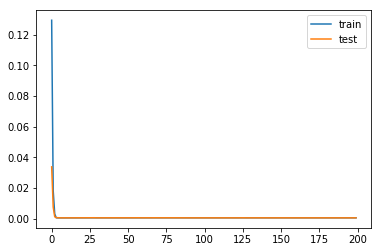

In [116]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [118]:
# make predictions
testPredict = model.predict(X_test)

In [119]:
testPredict

array([[0.21089518],
       [0.21333624],
       [0.20929556],
       ...,
       [0.10535457],
       [0.10791215],
       [0.10464412]], dtype=float32)

In [120]:
testPredict = yscaler.inverse_transform(testPredict)
testY = yscaler.inverse_transform([y_test])

In [121]:
testPredict

array([[4.412184 ],
       [4.4475355],
       [4.3890185],
       ...,
       [2.883745 ],
       [2.9207838],
       [2.8734562]], dtype=float32)

In [122]:
testY

array([[4.45900031, 4.38299992, 4.38600039, ..., 2.90100001, 2.86400004,
        2.84800009]])

In [123]:
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.3f RMSE' % (testScore))

Test Score: 0.067 RMSE


In [124]:
mape = mean_absolute_percentage_error(testY[0],testPredict[:,0])
print('Test MAPE: %.3f' % (mape))

Test MAPE: 1.816
